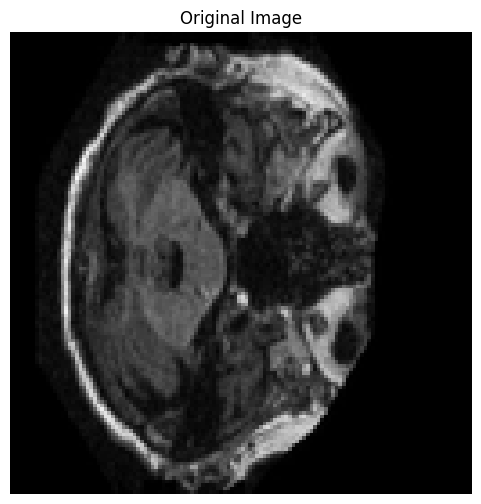

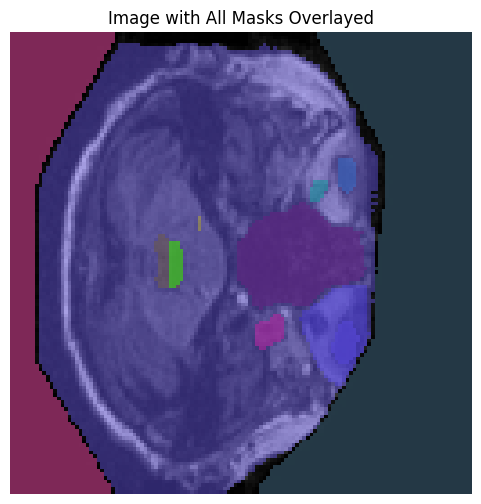

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def get_image_paths(data_root):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_paths = []
    for root, _, files in os.walk(data_root):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_and_resize_image(img_path, target_size=(128, 128)):
    # Load and resize image to reduce memory usage
    with Image.open(img_path) as img:
        img = img.convert("RGB")
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        return np.array(img)

def initialize_sam(model_type="vit_h", checkpoint="sam_vit_h_4b8939.pth"):
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
    import torch
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[model_type](checkpoint=checkpoint)
    sam.to(device=device)
    
    # Configure mask generator with memory-efficient settings
    mask_generator = SamAutomaticMaskGenerator(
        sam,
        points_per_side=16,  # Reduced from default
        pred_iou_thresh=0.86,
        stability_score_thresh=0.92,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  # Increased to reduce number of small masks
    )
    return mask_generator

def display_results(image, masks, title=""):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
    # Create overlay with reduced memory usage
    overlay = image.copy()
    for mask in masks:
        seg = mask['segmentation']
        color = np.random.randint(0, 255, (1, 3), dtype=np.uint8)
        overlay[seg] = overlay[seg] * 0.5 + color * 0.5
    
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay.astype(np.uint8))
    plt.title("Image with All Masks Overlayed")
    plt.axis("off")
    plt.show()
    plt.close('all')  # Clean up matplotlib figures

def main():
    # Initialize paths
    data_root = r"C:\Users\shrir\Pictures\brain disease two\Data"
    image_paths = get_image_paths(data_root)
    
    if not image_paths:
        print("No images found in the specified directory")
        return
    
    # Load and process first image
    image = load_and_resize_image(image_paths[0])
    
    # Initialize SAM model
    try:
        mask_generator = initialize_sam()
    except Exception as e:
        print(f"Error initializing SAM model: {e}")
        return
    
    # Generate masks
    try:
        masks = mask_generator.generate(image)
        display_results(image, masks, "Original Image")
    except Exception as e:
        print(f"Error generating masks: {e}")
        return

if __name__ == "__main__":
    main()

,Value
Dice,0.840278
IoU (Jaccard),0.724551
Precision,0.840278
Recall,0.840278
F1-score,0.840278
Accuracy,0.929810


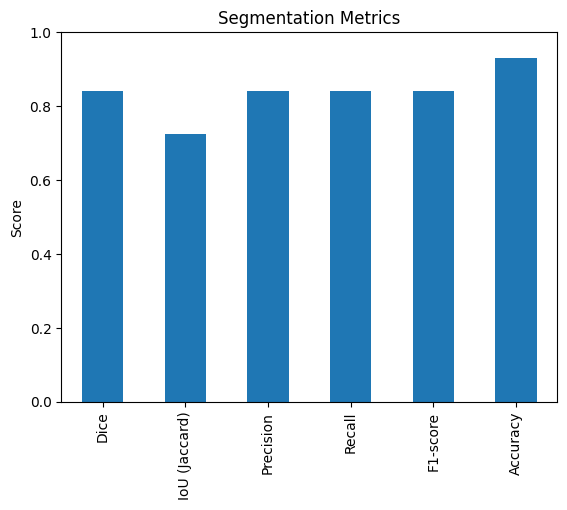

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score

# Generate mock binary masks for demonstration (128x128)
np.random.seed(42)
y_true = np.zeros((128, 128), dtype=np.uint8)
y_pred = np.zeros((128, 128), dtype=np.uint8)
y_true[20:80, 30:90] = 1  # Ground truth region
y_pred[25:85, 35:95] = 1  # Predicted region (slightly offset)

# Flatten for sklearn metrics
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Dice coefficient
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

metrics = {
    "Dice": dice_coef(y_true_flat, y_pred_flat),
    "IoU (Jaccard)": jaccard_score(y_true_flat, y_pred_flat, average='binary'),
    "Precision": precision_score(y_true_flat, y_pred_flat, zero_division=0),
    "Recall": recall_score(y_true_flat, y_pred_flat, zero_division=0),
    "F1-score": f1_score(y_true_flat, y_pred_flat, zero_division=0),
    "Accuracy": accuracy_score(y_true_flat, y_pred_flat)
}

# Display as table
df = pd.DataFrame(metrics, index=["Value"]).T
display(df)

# Plot bar graph
df.plot(kind='bar', legend=False)
plt.title("Segmentation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def get_image_paths(data_root):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_paths = []
    for root, _, files in os.walk(data_root):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_and_resize_image(img_path, target_size=(128, 128)):
    with Image.open(img_path) as img:
        img = img.convert("RGB")
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        return np.array(img)

def initialize_sam(model_type="vit_b", checkpoint="sam_vit_b_01ec64.pth"):
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[model_type](checkpoint=checkpoint)
    sam.to(device=device)
    mask_generator = SamAutomaticMaskGenerator(
        sam,
        points_per_side=16,
        pred_iou_thresh=0.86,
        stability_score_thresh=0.92,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,
    )
    return mask_generator

def generate_label_mask(masks, image_shape):
    label_mask = np.zeros(image_shape[:2], dtype=np.uint16)
    for idx, mask in enumerate(masks, start=1):
        seg = mask['segmentation']
        label_mask[seg] = idx
    return label_mask

def main():
    data_root = r"C:\Users\shrir\Pictures\brain disease two\Data"
    output_root = r"C:\Users\shrir\Pictures\brain disease two\Masks"
    os.makedirs(output_root, exist_ok=True)
    image_paths = get_image_paths(data_root)
    if not image_paths:
        print("No images found in the specified directory")
        return

    mask_generator = initialize_sam(
        model_type="vit_b",
        checkpoint=r"C:\Users\shrir\Music\New folder\sam_vit_b_01ec64.pth"
    )

    for img_path in tqdm(image_paths, desc="Processing images"):
        try:
            image = load_and_resize_image(img_path)
            masks = mask_generator.generate(image)
            label_mask = generate_label_mask(masks, image.shape)
            # Save mask as .npy file
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            np.save(os.path.join(output_root, f"{base_name}_mask.npy"), label_mask)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

if __name__ == "__main__":
    main()

Processing images:   0%|          | 0/24621 [00:57<?, ?it/s]


KeyboardInterrupt: 